# System Identification

System identification is the process of finding a transfer function that predicts outputs
that are close to those predicted by experimental data. These data
may be obtained from actual experiments for from a detailed nonlinear model.
System identification involves: iteratively choosing the size of the numerator and denominator polynomial
of the transfer function,
estimating the parameters of the transfer function, and evaluating the quality of the fit to
the predictions of the transfer function.

## Preliminaries

In [1]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.0.7'

## Models

### LINEAR_MODEL

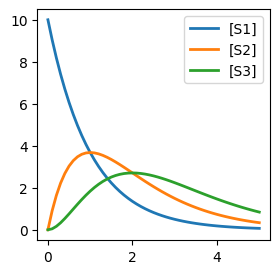

In [2]:
LINEAR_MODEL = """
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 1
k3 = 1
"""
rr = te.loada(LINEAR_MODEL)
rr.simulate()
rr.plot(figsize=(3,3))

In [3]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MODEL, input_names=["S1"], output_names=["S3"])

### WOLF_MODEL

In [4]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
WOLF_MODEL = rr.getAntimony()
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_names=["at_"], output_names=["s5"])
print(WOLF_MODEL)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

### MTOR_MODEL

In [5]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
rr = te.loadSBMLModel(MTOR_URL)
MTOR_MODEL = rr.getAntimony()
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_names=["pIR"], output_names=["mTORC1_DEPTOR"])
print(MTOR_MODEL)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

# Helpers

## Workaround for ``plotStaircaseResponse``

In [6]:
def plotStaircaseResponse(builder, is_plot=True, **kwargs):
    """
    This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
    It has the same arguments and return value as the original function.
    """
    plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
    # Plot if requested
    if is_plot:
        times = np.array(plot_result.time_series.index)/1000
        df = pd.DataFrame(plot_result.time_series)
        df.index = times
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (10, 10)
        legends = list(df.columns)
        fig, ax = plt.subplots(1, figsize=figsize)
        staircase_column = [c for c in df.columns if "staircase" in c][0]
        staircase_values = df[staircase_column].values
        del df[staircase_column]
        ax.plot(df)
        ax2 = ax.twinx()
        # Plot the staircase
        ax2.plot(times, staircase_values, color="red",
              linestyle="--")
        ax2.set_ylabel(staircase_column, color="red")
        ax.legend(df.columns)
    #
    return plot_result

# TESTS
if False:
    plot_response = plotStaircaseResponse(linear_builder, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                        legend_crd=(0.5, 1), end_time=100, is_plot=True)
    assert(isinstance(plot_response.time_series, ctl.Timeseries))
    print("OK!")

# Linear model transfer function

In this section, we use LINEAR_MODEL to illustrate system identification.
The work can be simplied by making use of the ``SISOTransferFunctionBuilder``
object in ``ControlSBML``.

## Step 1. Construct the ``SISOTransferFunctionBuilder``

``SISOTransferFunctonBuilder`` is a ``controlSBML`` object that faciliates system identification
of transfer functions for SBML models.

In [7]:
linear_builder = LINEAR_CTLSB.makeSISOTransferFunctionBuilder()
linear_builder.input_name, linear_builder.output_name

('S1', 'S3')

## Step 2. Determine the operating region

The operating region is the range of control inputs that should handled by the controller.
We want to see how responsive the system is to the possible outputs from the controller.
We assess the operating region by using a *staircase input*.
This is a sequence of steps of the same height that have a duration that is sufficiently
long so that the system stabilizes.

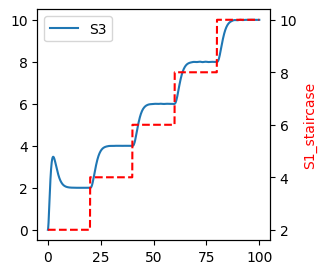

In [8]:
plotStaircaseResponse(linear_builder, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=100)

## Step 3. Find the transfer function

To fit a transfer function, we must specify the number of terms in the
numerator and denominator polynomials for the transfer function.

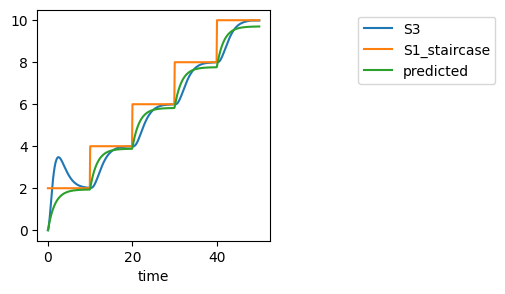

In [9]:
num_degree = 0
denom_degree = 1
fitter_result = linear_builder.fitTransferFunction(num_degree + 1, denom_degree + 1, 
                                                   final_value=10,
                                                   initial_value=2, end_time=50)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

In [10]:
tf = fitter_result.transfer_function
tf

TransferFunction(array([0.04239373]), array([0.07168574, 0.04367874]))

This plot displays values of ``S3`` in response to values of ``S1``.
We see that the output closely follows the input, and that there is a response over
the entire range of input.

In [11]:
tf.dcgain()

0.9705804057990304

In [12]:
tf.poles()

array([-0.60930871+0.j])

In [13]:
fitter_result.nfev

76

## Step 4. Analyze the fit result

``fitter_result`` has many useful properties.
* ``minimizer_result`` contains detailed information about the results of the optimization
* ``nfev`` is the number of different transfer functions that were evaluated to find the fit
* ``parameters`` contains the parameter values
* ``redchi`` is the reduced ChiSq for the fit
* ``stderr`` contains the standard deviations of the parameter values
* ``time_series`` is a ``Timeseries`` object with the input, nonlinear simulated output, and predicted value of the output
* ``transfer_function`` is the fitted transfer function

In [14]:
fitter_result.parameters

name,value,standard error,relative error,initial value,min,max,vary
n0,0.04239373,1648.82903,(3889322.52%),0.1,-10.0000000,10.0000000,True
d0,0.07168574,2787.69486,(3888771.96%),0.1,-10.0000000,10.0000000,True
d1,0.04367874,1698.81989,(3889351.47%),0.1,-10.0000000,10.0000000,True


In [15]:
fitter_result.transfer_function

TransferFunction(array([0.04239373]), array([0.07168574, 0.04367874]))


      0.04239
-------------------
0.07169 s + 0.04368



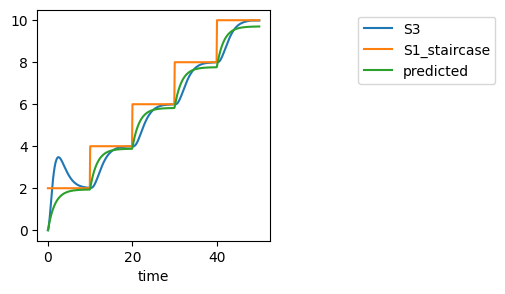

In [16]:
print(fitter_result.transfer_function)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2, 1))

#  Wolf Transfer Function

In [17]:
wolf_builder = WOLF_CTLSB.makeSISOTransferFunctionBuilder()
wolf_builder.input_name, wolf_builder.output_name

('at_', 's5')

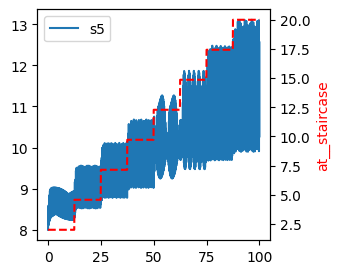

In [18]:
plotStaircaseResponse(wolf_builder, initial_value=2, final_value=20, figsize=(3,3),
                                    num_step=8, legend_crd=(0.5, 1), end_time=100)


5.305 s^3 + 0.4604 s^2 + 0.5319 s + 0.0006251
---------------------------------------------
 2.05 s^3 + 0.355 s^2 + 0.09015 s + 0.005904



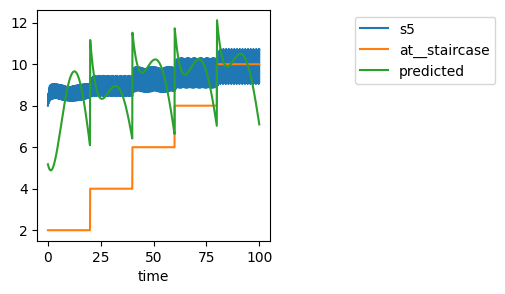

In [19]:
fitter_result = wolf_builder.fitTransferFunction(4, 4, final_value=10,
                                                   initial_value=2, end_time=100)
print(fitter_result.transfer_function)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2, 1))

In [20]:
fitter_result.transfer_function.dcgain()

0.10587808711218334

Is this model sufficiently accurate to do control design?

The key consideration here is accuracy of DC Gain. How do the step increases in input relate to the magnitude of the increase in output?

# mTOR transfer function

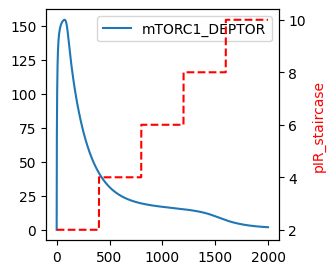

In [21]:
mtor_builder = MTOR_CTLSB.makeSISOTransferFunctionBuilder()
plotStaircaseResponse(mtor_builder, initial_value=2, final_value=10, figsize=(3,3),
                                    legend_crd=(2, 1), end_time=2000)

There does not seem to be a relationship between the step input and the output.

# Metformin in Mice (MODEL2206230001)

This is a whole-body model representing the pharmacokinetics of metformin in the mouse body. The model is in the form of ordinary differential equations and describes metformin concentration in 20 compartments. The model consists of 20 compartments (“Compartments” in COPASI model) describing various tissues or tissue sub-compartments and body fluids of metformin action (venous and arterial plasma, intestine, kidney, heart, fat, muscle, brain, lungs, stomach, liver, portal vein, remainder urine and feces).

In [22]:
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
ctlsb = ctl.ControlSBML(url, input_names=["mIntestineVascular"], output_names=["mMuscle"])
#print(ctlsb.antimony)
METFORMIN_BUILDER = ctlsb.makeSISOTransferFunctionBuilder()

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Cannot calculate Jacobian because Could not set value for Liver, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData *, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int *, const double *, bool)

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Cannot calculate Jacobian because Could not set value for Liver, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData *, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int *, const double *, bool)



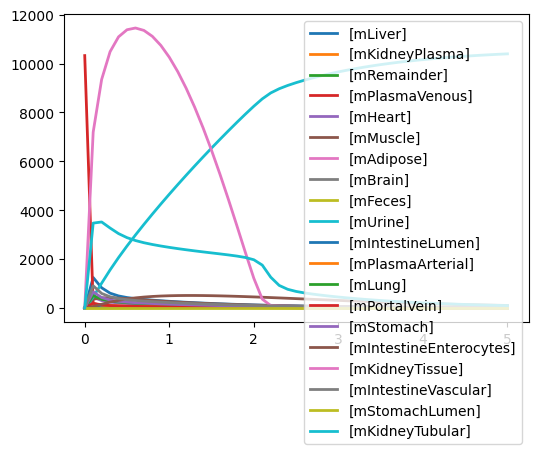

In [23]:
ctlsb.roadrunner.simulate()
ctlsb.roadrunner.plot()

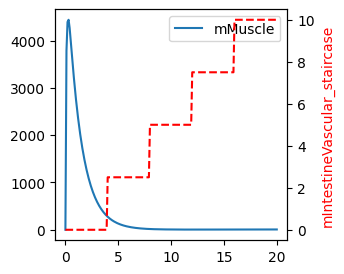

In [24]:
plotStaircaseResponse(METFORMIN_BUILDER, final_value=10, figsize=(3,3), end_time=20)